In [5]:
# importing the dependent libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from tensorflow.keras import optimizers
import seaborn as sns
from scipy import stats
from scipy.stats import skew, norm, probplot, boxcox
from scipy.special import boxcox1p
import scipy
import tensorflow as tf
from tensorflow import keras

# Bayesian Optimization
import skopt
from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
from skopt.utils import use_named_args
#from skopt.plots import plot_histogram, plot_objective

In [14]:
data = pd.read_csv('pressure_loss.csv')
data['diff_p'] = data['diff_p']*0.24884
data = data.drop(['annulus','test_fluid'],axis=1)
dataset = data.values
x = dataset[:,:6]
y = dataset[:,6:]
scale_1 = MinMaxScaler(feature_range=(0,1))
scale_2 = MinMaxScaler(feature_range=(0,1))
x_scale = scale_1.fit_transform(x)
y_scale = scale_2.fit_transform(y)
# splitting the data
x_train,x_val, y_train,y_val = train_test_split(x_scale,y_scale,test_size=0.3)

In [15]:
# define learning rate for skopt
dim_learning_rate = Real(low=1e-6,high=1e-2,prior='log-uniform',name='learning_rate')

# define num_neurons
dim_neurons = Integer(low=1,high=40,name='num_neurons')

# define number of layers 
dim_layers = Integer(low=1,high=40,name='num_layers')

# define axtivation function
dim_activation = Categorical(categories=['relu','sigmoid','tanh'],name='act')

# define the dropout 
dim_dropout = Real(low=0.0001,high = 0.3,name='dropout')

In [16]:
# define the total dimenison to be considered in the study
dimensions = [dim_neurons,
             dim_layers,
             dim_learning_rate,
             dim_activation,
             dim_dropout]

In [17]:
# define the total dimenison to be considered in the study
dimensions = [dim_neurons,
             dim_layers,
             dim_learning_rate,
             dim_activation,
             dim_dropout]

In [18]:
# Optimizing the ANN with Bayesian Optimization method
# generalized neural network
# Define the model for the bayesian optimization
# define a base case of ANN applicable for allthe cases and optimization
# importing the basic libraries
# Define the neural network
def create_model(num_neurons,num_layers,learning_rate,act,
                   dropout):
    
    """
    Hyperparameters 
    num_neurons:     Number of neurons in a layer
    num_layers:      Number of hidden layer in the ANN
    input_dim:       Shape of the input data into first layer
    output_dim:      Number of classes to be predicted
    learning_rate:   Learning rate of the optimizer
    activation:      Activation function of the layer
    optimization:    Optimization algorithms to be used
    dropout:         Define the rate of dropout 
    """
    
    #set random seed for reproducibility
    np.random.seed(42)
    #set_random_seed(42)
    
    # start the construction of keras Sequential Model
    model = Sequential()
    
    # Add an input layer 
    model.add(Dense(num_neurons,activation='relu',input_dim=6))
    
    # Iterate for the additional layers
    for i in range(1,num_layers):
        model.add(Dense(num_neurons,activation=act))
        
    # Add the droppout layer
    model.add(Dropout(dropout))
        
    # add the last layer
    model.add(Dense(1,activation='linear'))
    
    # define the optimization function
    adam = optimizers.Adam(lr=learning_rate)
    
    # Compiling the model 
    model.compile(adam,
                  loss='mean_squared_error',
                  metrics=['mse']
                 )
    return model


In [19]:
# define the best accuracy of the model 
best_accuracy = 0.0
path_best_model = 'show.best_model.keras'

In [20]:
# Default parameters for the above described model
default_parameter = [7,3,0.001,'relu',0.001]

In [21]:
# coding the fitness function

@use_named_args(dimensions=dimensions)
def fitness(num_neurons,num_layers,learning_rate,act,dropout):
    
    # print the hyperparameters
    print('Number of Neurons: ',num_neurons)
    print('Nuber of Layers: ',num_layers)
    print('Learning Rate: {0:.1e}'.format(learning_rate))
    print('Activation Function: ',act)
    print('Dropout: ',dropout)
    
    # create the neural network with these hyperparameters
    model = create_model(num_neurons=num_neurons
                         ,num_layers=num_layers
                         ,learning_rate=learning_rate
                         ,act=act
                         ,dropout=dropout)
    
    # use keras to train the model
    history = model.fit(x=x_train,
                       y=y_train,
                       epochs=5,
                       batch_size=16,
                       validation_split=0.20,
                       verbose=0)
    
    # get the classification accuracy on the validation dataset after last training 
    accuracy = history.history['val_loss'][-1]
    
    # print the classification accuracy
    print()
    print('Loss: {0:.2%}'.format(accuracy))
    print()
    
    global best_accuracy
    if accuracy<best_accuracy:
        model.save(path_best_model)
        best_accurcay = accuracy
    del model
    return accuracy

In [54]:
fitness(x=default_parameter)

Number of Neurons:  7
Nuber of Layers:  3
Learning Rate: 1.0e-03
Activation Function:  relu
Dropout:  0.001

Loss: 1.70%



0.0169874136519479

In [55]:
search_result = gp_minimize(func=fitness,
                           dimensions=dimensions,
                           acq_func='EI',
                           n_calls=50,
                           x0=default_parameter)

Number of Neurons:  7
Nuber of Layers:  3
Learning Rate: 1.0e-03
Activation Function:  relu
Dropout:  0.001

Loss: 3.97%

Number of Neurons:  16
Nuber of Layers:  38
Learning Rate: 8.5e-04
Activation Function:  sigmoid
Dropout:  0.046889990268686725

Loss: 4.65%

Number of Neurons:  16
Nuber of Layers:  38
Learning Rate: 8.5e-04
Activation Function:  sigmoid
Dropout:  0.046889990268686725

Loss: 4.66%

Number of Neurons:  16
Nuber of Layers:  38
Learning Rate: 8.5e-04
Activation Function:  sigmoid
Dropout:  0.046889990268686725

Loss: 4.57%

Number of Neurons:  16
Nuber of Layers:  38
Learning Rate: 8.5e-04
Activation Function:  sigmoid
Dropout:  0.046889990268686725

Loss: 4.64%

Number of Neurons:  16
Nuber of Layers:  38
Learning Rate: 8.5e-04
Activation Function:  sigmoid
Dropout:  0.046889990268686725

Loss: 4.56%

Number of Neurons:  16
Nuber of Layers:  38
Learning Rate: 8.5e-04
Activation Function:  sigmoid
Dropout:  0.046889990268686725

Loss: 4.64%

Number of Neurons:  16
Nub

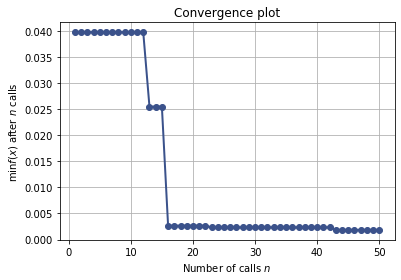

In [56]:
# plot the convergence of the fitness function
plot_convergence(search_result);

In [57]:
# best hyper parameters
search_result.x

[40, 13, 0.0015985572878205064, 'relu', 0.13998523423646897]

In [58]:
space = search_result.space
search_result.fun

0.0018399823672416817

In [59]:
sorted(zip(search_result.func_vals,search_result.x_iters))

[(0.0018399823672416817,
  [40, 13, 0.0015985572878205064, 'relu', 0.13998523423646897]),
 (0.0023179996408536794,
  [5, 22, 0.0029506119371934827, 'relu', 0.11263738798204785]),
 (0.002655855961158637, [26, 9, 0.01, 'relu', 0.0061249741482980935]),
 (0.0027617777892073076, [40, 3, 0.01, 'sigmoid', 0.16272161916370845]),
 (0.00300239134803561,
  [40, 37, 0.000643190894126107, 'tanh', 0.21036054754616587]),
 (0.003661383575884493, [40, 1, 0.0035250454186137067, 'relu', 0.0001]),
 (0.004258993177997374, [40, 20, 0.001731835155508845, 'relu', 0.0001]),
 (0.006243824045811816, [40, 1, 0.01, 'sigmoid', 0.0001]),
 (0.007516969589325856, [40, 1, 0.01, 'relu', 0.0001]),
 (0.007980353558274705, [31, 11, 0.01, 'tanh', 0.004108603435711055]),
 (0.009134037797815922, [27, 1, 0.003129110229952164, 'relu', 0.0001]),
 (0.014377738829467475, [40, 23, 0.00015561205683012073, 'relu', 0.3]),
 (0.017296143653472578,
  [40, 1, 0.0005145204388124426, 'relu', 0.28767823578801566]),
 (0.01766880758209374, [40

Text(0, 0.5, 'Number of Neurons')

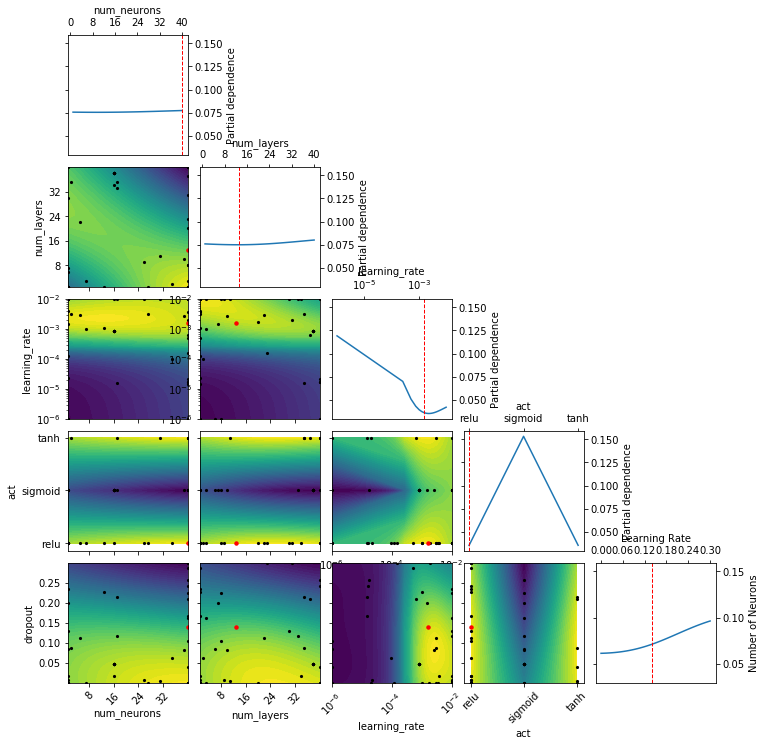

In [60]:
fig = plot_objective(result=search_result,
                       #dimension_name1='learning_rate',
                       #dimension_name2='num_neurons',
                       levels=50)
plt.xlabel('Learning Rate')
plt.ylabel('Number of Neurons')
#plt.savefig('lr_neurons.jpeg')

In [61]:
test_model = create_model(35,16,0.006681727541638011,'relu',
                   0.030734643944295682)

In [62]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs):
        if epoch%100 ==0: print('')
        print('.',end='')


In [63]:
history_test = test_model.fit(x_train,y_train,batch_size=16, epochs=1000,validation_split=0.2,
                    verbose=0,callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [64]:
hist_test = pd.DataFrame(history_test.history)
hist_test['epoch'] = history_test.epoch
hist_test.tail()

,loss,mse,val_loss,val_mse,epoch
995,0.000621,0.000621,0.001144,0.001144,995
996,0.001008,0.001008,0.000703,0.000703,996
997,0.000586,0.000586,0.000733,0.000733,997
998,0.000618,0.000618,0.000682,0.000682,998
999,0.001629,0.001629,0.000952,0.000952,999


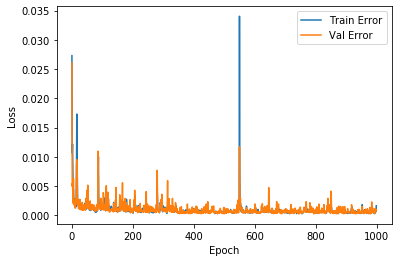

In [65]:
def plot_histry(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
#     plt.figure()
#     plt.xlabel('Epoch')
#     plt.ylabel('Mean Absolute Error')
#     plt.plot(hist['epoch'],hist['mean_absolute_error'],label='Train Error')
#     plt.plot(hist['epoch'],hist['val_mean_absolute_error'],label='Val Error')
#     plt.legend()
    
#     plt.figure()
#     plt.xlabel('Epoch')
#     plt.ylabel('Mean Square Error')
#     plt.plot(hist['epoch'],hist['mean_squared_error'],label='Train Error')
#     plt.plot(hist['epoch'],hist['val_mean_squared_error'],label='Val Error')
#     plt.legend()
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'],hist['loss'],label='Train Error')
    plt.plot(hist['epoch'],hist['val_loss'],label='Val Error')
    plt.legend()

    
plot_histry(history_test)

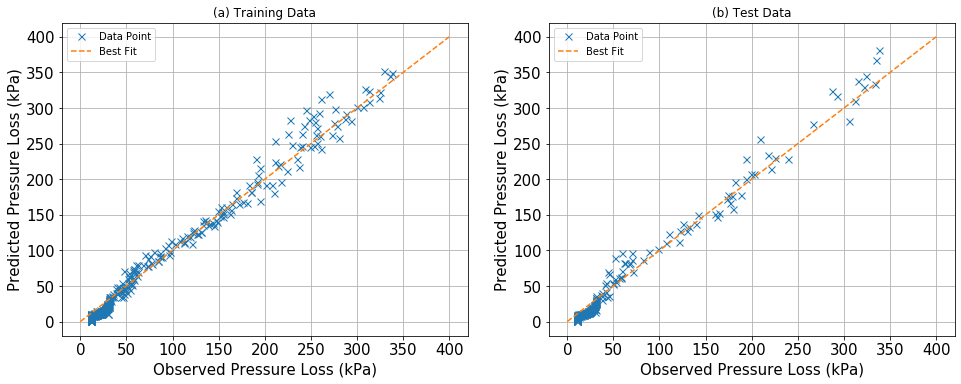

In [67]:
# plot trainning and test data 
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
#fig.suptitle('Bayesian Neural Network', fontsize=16)
fig.subplots_adjust(top=.85, wspace=0.2)

# first track
ax[0].plot(scale_2.inverse_transform(test_model.predict(x_train)),scale_2.inverse_transform(y_train),'x',label='Data Point',ms=7)
ax[0].set_ylabel('Predicted Pressure Loss (kPa)',fontsize=15)
ax[0].set_xlabel('Observed Pressure Loss (kPa)',fontsize=15)
ax[0].grid(True)
ax[0].set_title('(a) Training Data')
ax[0].plot([0,400],[0,400],'--',label='Best Fit')
ax[0].tick_params(labelsize=15)
ax[0].legend()

# second track
ax[1].plot(scale_2.inverse_transform(test_model.predict(x_val)),scale_2.inverse_transform(y_val),'x',label='Data Point',ms=7)
ax[1].set_ylabel('Predicted Pressure Loss (kPa)',fontsize=15)
ax[1].set_xlabel('Observed Pressure Loss (kPa)',fontsize=15)
ax[1].grid(True)
ax[1].set_title('(b) Test Data')
ax[1].plot([0,400],[0,400],'--',label='Best Fit')
ax[1].tick_params(labelsize=15)
ax[1].legend()

#plt.savefig('Bayesian_ANN.jpeg',dpi=200)